<a href="https://colab.research.google.com/github/macsz/issondl2021_workshop/blob/wip/5_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalanced dataset

## Imports

In [1]:
import math
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve,\
precision_recall_curve, plot_precision_recall_curve, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1.logging import INFO, set_verbosity
from tensorflow.keras.models import Model
from tqdm import tqdm

random.seed(2021)
set_verbosity(INFO)

## Constants

In [2]:
DATA_DIR = 'data/'
CSV_FILE = os.path.join(DATA_DIR, 'binary_biased_wsweights_29.csv')
IMAGES_ARCHIVE_FILE = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_256x256.tar.gz')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')

os.makedirs(DATA_DIR, exist_ok=True)

## Check for acceleration

In [3]:
!nvidia-smi

Sun Jul  4 13:43:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get files

In [4]:
if not os.path.exists(CSV_FILE):
    ! gdown --id 13e8MugScdW2LeGlqZornhYJ3pkRl78QK -O $CSV_FILE
else:
    print('CSV file ({}) already exists.'.format(CSV_FILE))

CSV file (data/binary_biased_wsweights_29.csv) already exists.


In [5]:
if not os.path.exists(IMAGES_ARCHIVE_FILE):
    ! gdown --id 1Cg7dbE1tWSBvdTfGc0G272SA_j_XocOW -O $IMAGES_ARCHIVE_FILE
else:
    print('Images archive file ({}) already exists.'.format(IMAGES_ARCHIVE_FILE))

Images archive file (data/nih_chest_xray_single_9c_256x256.tar.gz) already exists.


In [6]:
if not os.path.exists(IMAGES_DIR):
    ! tar -xzf $IMAGES_ARCHIVE_FILE
    print('Unpacked to {}'.format(IMAGES_DIR))
else:
    print('Images have already been unpacked ({}).'.format(IMAGES_DIR))

Images have already been unpacked (data/images).


## Explore Dataset

In [7]:
df = pd.read_csv(CSV_FILE)
df[df.columns[::-1]]

,sample weight,Finding_ID,Patient_Gender_ID,File Path,Pneumothorax,Pneumonia,Nodule,No Finding,Mass,Infiltration,Effusion,Cardiomegaly,Atelectasis,bb_h,bb_w,bb_y,bb_x,Patient Gender,Patient Age,Finding Labels,Image Index,Unnamed: 0
0,1.762872,8,0,data/images/00000118_011.png,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,M,73,Pneumothorax,00000118_011.png,176
1,0.868697,5,0,data/images/00000148_000.png,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,M,59,No Finding,00000148_000.png,207
2,0.868697,5,0,data/images/00000252_001.png,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,M,46,No Finding,00000252_001.png,350
3,1.762872,8,0,data/images/00000285_006.png,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,M,49,Pneumothorax,00000285_006.png,381
4,0.868697,5,0,data/images/00000322_004.png,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,M,33,No Finding,00000322_004.png,410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,0.868697,5,0,data/images/00030542_000.png,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,M,73,No Finding,00030542_000.png,36348
842,1.762872,8,0,data/images/00030606_007.png,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,M,58,Pneumothorax,00030606_007.png,36402
843,1.762872,8,0,data/images/00030606_009.png,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,M,58,Pneumothorax,00030606_009.png,36403
844,0.868697,5,0,data/images/00030609_003.png,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,M,6,No Finding,00030609_003.png,36410


## Prepare Data for Training and Testing

We will be doing binary classification: No Finding vs Pneumothorax.

Tasks:


1.   Make sure there are no rows with category that is not used.
2.   Drop redundant columns.



In [8]:
## We will be doing binary classification: No Finding vs Pneumothorax.
## Make sure there are no rows with category that is not used.
## Drop redundant columns. 
df.sum()

labels_to_drop = [
  'Unnamed: 0', 'Atelectasis', 'Cardiomegaly', 'Infiltration', 'Nodule',
  'Pneumonia', 'Effusion', 'Mass', 'bb_x', 'bb_y', 'bb_h', 'bb_w']
  #'No Finding', 'Pneumothorax']

df.drop(labels_to_drop, axis=1, inplace=True)

print(len(df))

846


In [9]:
df

,Image Index,Finding Labels,Patient Age,Patient Gender,No Finding,Pneumothorax,File Path,Patient_Gender_ID,Finding_ID,sample weight
0,00000118_011.png,Pneumothorax,73,M,0,1,data/images/00000118_011.png,0,8,1.762872
1,00000148_000.png,No Finding,59,M,1,0,data/images/00000148_000.png,0,5,0.868697
2,00000252_001.png,No Finding,46,M,1,0,data/images/00000252_001.png,0,5,0.868697
3,00000285_006.png,Pneumothorax,49,M,0,1,data/images/00000285_006.png,0,8,1.762872
4,00000322_004.png,No Finding,33,M,1,0,data/images/00000322_004.png,0,5,0.868697
...,...,...,...,...,...,...,...,...,...,...
841,00030542_000.png,No Finding,73,M,1,0,data/images/00030542_000.png,0,5,0.868697
842,00030606_007.png,Pneumothorax,58,M,0,1,data/images/00030606_007.png,0,8,1.762872
843,00030606_009.png,Pneumothorax,58,M,0,1,data/images/00030606_009.png,0,8,1.762872
844,00030609_003.png,No Finding,6,M,1,0,data/images/00030609_003.png,0,5,0.868697


In [10]:
LABELS = df.columns[4]
LABELS

'No Finding'

All: 846
Train: 592
Val: 127
Test: 127


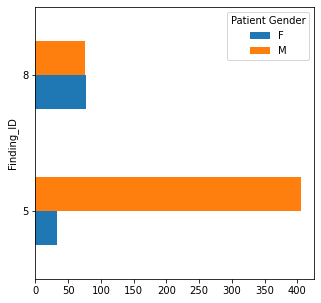

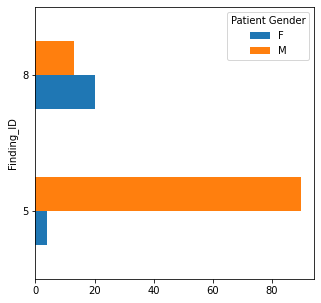

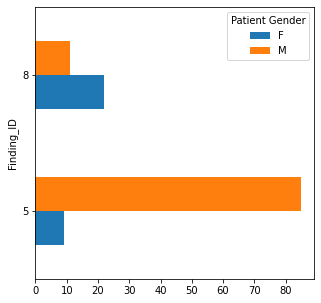

In [11]:
TEST_SIZE = 0.3

df = df.reindex(np.random.permutation(df.index))

train_df, tmp_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    stratify=df['Finding Labels']
)

half = int(len(tmp_df)/2)

# Testing set (top half of the remainder)
test_df = tmp_df[:half]

# Validation set (bottom one)
val_df = tmp_df[-half:]

print('All: {}'.format(len(df)))
print('Train: {}'.format(len(train_df)))
print('Val: {}'.format(len(val_df)))
print('Test: {}'.format(len(test_df)))

train_df.groupby('Patient Gender')['Finding_ID'].value_counts().unstack(0).plot.barh(figsize=(5,5))
val_df.groupby('Patient Gender')['Finding_ID'].value_counts().unstack(0).plot.barh(figsize=(5,5))
test_df.groupby('Patient Gender')['Finding_ID'].value_counts().unstack(0).plot.barh(figsize=(5,5))

In [12]:
BATCH_SIZE = 64
IMAGE_SIZE = [240, 240]

In [13]:
def get_train_generator(df, x_col, y_cols, batch_size, target_image_size, seed=2021):
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip=False, 
        fill_mode='reflect'
    )

    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        x_col=x_col,
        y_col=y_cols,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        target_size=target_image_size,
    )
    
    return generator

train_generator = get_train_generator(
    df = train_df,
    x_col="File Path",
    y_cols=LABELS,
    batch_size=BATCH_SIZE,
    target_image_size=IMAGE_SIZE,
)

Found 592 validated image filenames.


Tasks:


1.   Create 3 test generators: 1 with all examples, 1 with only female, 1 with only male



In [14]:
def get_test_and_valid_generator(val_df, test_df, train_df, x_col, y_cols, sample_size, batch_size, target_image_size, seed=2021):
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=target_image_size
    )
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True,
    )
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get valid generator
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=target_image_size,
    )
    
    ## create 3 test generator: 1 with all examples, 1 with only female, 1 with only male
    ## START
    test_df_M = test_df[test_df['Patient_Gender_ID'] == 0]
    test_df_F = test_df[test_df['Patient_Gender_ID'] == 1]

    test_generator_F = image_generator.flow_from_dataframe(
        dataframe=test_df_F,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=target_image_size
    )
    
    test_generator_M = image_generator.flow_from_dataframe(
        dataframe=test_df_M,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=target_image_size
    )

    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=target_image_size
    )
    ## END
    return valid_generator, test_generator_F, test_generator_M, test_generator

val_generator, test_generator_F, test_generator_M, test_generator = get_test_and_valid_generator(
    val_df=val_df,
    test_df=test_df,
    train_df=train_df,
    x_col="File Path",
    y_cols=LABELS,
    batch_size=BATCH_SIZE,
    target_image_size=IMAGE_SIZE,
    sample_size=100,
)


Found 592 validated image filenames.
Found 127 validated image filenames.
Found 31 validated image filenames.
Found 96 validated image filenames.
Found 127 validated image filenames.


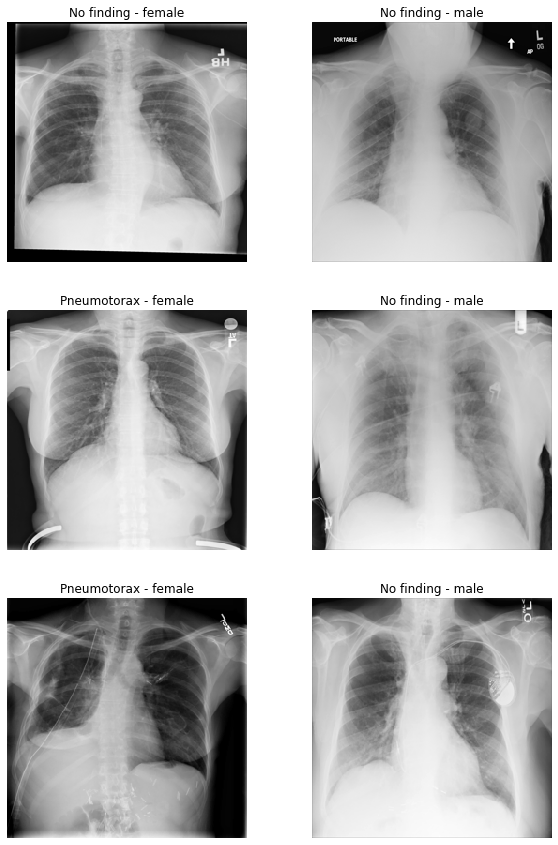

In [15]:
x_f, y_f = test_generator_F.__getitem__(0)
x_m, y_m = test_generator_M.__getitem__(0)

samples = 3
columns = 2
rows = samples

id2cat = {1:'No finding', 0:'Pneumotorax'}
fig = plt.figure(figsize=(10, 5*rows))
for i in range(0, rows*columns, columns):
    label_f = id2cat[y_f[i]]
    label_m = id2cat[y_m[i]]
    img_f = tf.keras.preprocessing.image.array_to_img(x_f[i//columns])
    img_m = tf.keras.preprocessing.image.array_to_img(x_m[i//columns])

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img_f)
    plt.title('{} - female'.format(label_f))
    plt.axis(False)
    
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(img_m)
    plt.title('{} - male'.format(label_m))
    plt.axis(False)

Examples:
    Total: 592
    Positive: 439 (74.16% of total)



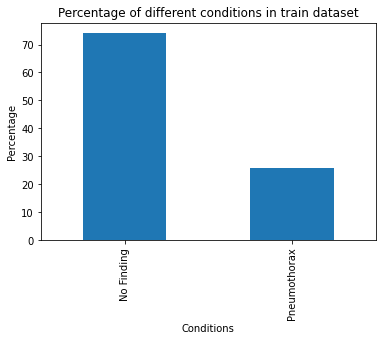

In [16]:
neg, pos = np.bincount(train_df[LABELS])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

(train_df['Finding Labels'].value_counts()/len(train_df)*100).plot(kind='bar',
  title='Percentage of different conditions in train dataset',
  xlabel='Conditions',
  ylabel='Percentage')

Tasks:


1.   Calculate weights for classes and store them in dict



In [17]:
## Calculate weights for classes and store them in dict
def create_class_weight(y, pos, neg, total):
  ## START
  total = len(y)
  keys = y.unique()
  class_weight = dict()
    
  for key in keys:
    if key == 1:
      # Scaling by total/2 helps keep the loss to a similar magnitude.
      # The sum of the weights of all examples stays the same.
      score = math.log((1 / pos) * (total / 2.0))
    else:
      score = math.log((1 / neg) * (total / 2.0))
    class_weight[key] = score if score > 1.0 else 1.0 
    
  return class_weight

class_weight = create_class_weight(train_df[LABELS], pos, neg, total)

Tasks:


1. Define METRICS using tf.keras.metrics
2. Initial guesses are not good, we know dataset is imbalanced. Set the output layer's bias to reflect that. Derive initial bias $b_0$ from: $p_0=\frac{neg}{(pos+neg)}=\frac{1}{1+e^{-b_0}}$ and add it to the last Dense layer as bias_initializer.



In [18]:
## Define METRICS using tf.keras.metrics
## START
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
## END

## Set the output layer's bias to reflect class imbalance
## START
initial_bias = np.log([neg/pos])
## END

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64,(3,3),padding='same',input_shape=(*IMAGE_SIZE, 3)),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Conv2D(32,(3,3)),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
        ## START
        bias_initializer=output_bias),
        ## END
  ])
  lr = 1e-4
  loss = tf.keras.losses.BinaryCrossentropy()
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    loss=loss,
    metrics=METRICS,
  )
  return model


model = make_model(output_bias=initial_bias)
initial_weights = 'initial_weights'
model.save_weights(initial_weights)

model_1 = make_model()
model_1.load_weights(initial_weights)
model_2_class = make_model()
model_2_class.load_weights(initial_weights)
model_2_class.layers[-1].bias.assign([0.0])
model_3_class_sample = make_model()
model_3_class_sample.load_weights(initial_weights)
model_3_class_sample.layers[-1].bias.assign([0.0])

model.summary()

#Note: Using class_weights changes the range of the loss.
#This may affect the stability of the training depending on the optimizer.
#Optimizers whose step size is dependent on the magnitude of the gradient,
#like tf.keras.optimizers.SGD, may fail. The optimizer used here,
#tf.keras.optimizers.Adam, is unaffected by the scaling change.
#Also note that because of the weighting, the total losses are not comparable between the two models.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 240, 240, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 238, 32)      18464     
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 453152)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [19]:
def train_generator_sample_weights():
    batch = 0
    for s in train_generator:
        sample_weights = np.array(train_df[BATCH_SIZE*batch:(batch+1)*BATCH_SIZE]['sample weight'])
        if len(sample_weights) < len(s[0]):
            sample_weights_tmp = np.ones((64))
            sample_weights_tmp[:len(sample_weights)] = sample_weights
            sample_weights = sample_weights_tmp
        if len(sample_weights) > len(s[0]):
            sample_weights = sample_weights[:len(s[0])]
        batch += 1
        if batch > len(train_generator):
            batch = 0
        yield (s[0], s[1], sample_weights)

In [ ]:
EPOCHS = 500

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)

history_1 = model_1.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs = EPOCHS,
    callbacks=[early_stopping],
    batch_size=BATCH_SIZE,
)

history_2_class = model_2_class.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs = EPOCHS,
    class_weight=class_weight,
    callbacks=[early_stopping],
    batch_size=BATCH_SIZE,
)

history_3_class_sample = model_3_class_sample.fit(
    train_generator_sample_weights(),
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs = EPOCHS,
    callbacks=[early_stopping],
    batch_size=BATCH_SIZE,
)

Epoch 1/500
10/10 [==============================] - 12s 824ms/step - loss: 1.0556 - tp: 313.0000 - fp: 100.0000 - tn: 53.0000 - fn: 126.0000 - accuracy: 0.6182 - precision: 0.7579 - recall: 0.7130 - auc: 0.5394 - prc: 0.7661 - val_loss: 0.5803 - val_tp: 93.0000 - val_fp: 32.0000 - val_tn: 1.0000 - val_fn: 1.0000 - val_accuracy: 0.7402 - val_precision: 0.7440 - val_recall: 0.9894 - val_auc: 0.6077 - val_prc: 0.7871
Epoch 2/500
10/10 [==============================] - 8s 743ms/step - loss: 0.6355 - tp: 395.0000 - fp: 126.0000 - tn: 27.0000 - fn: 44.0000 - accuracy: 0.7128 - precision: 0.7582 - recall: 0.8998 - auc: 0.5464 - prc: 0.7581 - val_loss: 0.5709 - val_tp: 86.0000 - val_fp: 29.0000 - val_tn: 4.0000 - val_fn: 8.0000 - val_accuracy: 0.7087 - val_precision: 0.7478 - val_recall: 0.9149 - val_auc: 0.6428 - val_prc: 0.8061
Epoch 3/500
10/10 [==============================] - 8s 745ms/step - loss: 0.6016 - tp: 375.0000 - fp: 121.0000 - tn: 32.0000 - fn: 64.0000 - accuracy: 0.6875 - pre

In [ ]:
def visualize_training(*args, lw=3):
    fig, axs = plt.subplots(len(args), 2)
    fig.set_size_inches(12, len(args)*5)

    row = 0
    for history, name in args:
        axs[row, 0].plot(history.history['auc'], label = 'training', marker = '*', linewidth = lw)
        axs[row, 0].plot(history.history['val_auc'], label = 'validation', marker = 'o', linewidth = lw)
        axs[row, 0].set_title('{} - Training Accuracy vs Validation Accuracy'.format(name))

        axs[row, 1].plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
        axs[row, 1].plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
        axs[row, 1].set_title('{} - Training Loss vs Validation Loss'.format(name))
        row += 1

In [ ]:
visualize_training((history_1, 'history_1'), (history_2_class, 'history_2_class'), (history_3_class_sample, 'history_3_sample'))

In [ ]:
predicted_vals_F_1 = model_1.predict(test_generator_F, steps=len(test_generator_F))
predicted_vals_M_1 = model_1.predict(test_generator_M, steps=len(test_generator_M))
predicted_vals_1 = model_1.predict(test_generator, steps=len(test_generator))

predicted_vals_F_2_class = model_2_class.predict(test_generator_F, steps=len(test_generator_F))
predicted_vals_M_2_class = model_2_class.predict(test_generator_M, steps=len(test_generator_M))
predicted_vals_2 = model_2_class.predict(test_generator, steps=len(test_generator))

predicted_vals_F_3_class_sample = model_3_class_sample.predict(test_generator_F, steps=len(test_generator_F))
predicted_vals_M_3_class_sample = model_3_class_sample.predict(test_generator_M, steps=len(test_generator_M))
predicted_vals_3 = model_3_class_sample.predict(test_generator, steps=len(test_generator))

In [ ]:
def get_roc_curve(labels, *args):

    fig, axs = plt.subplots(1, len(args))
    fig.set_size_inches(15, 3)

    for idx, (predicted_vals, generator, name, sample_weight) in enumerate(args):
        auc_roc_vals = []
        gt = generator.labels[:]
        pred = predicted_vals[:]
        auc_roc = roc_auc_score(gt, pred, sample_weight=sample_weight)
        auc_roc_vals.append(auc_roc)
        fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
        
        axs[idx].plot([0, 1], [0, 1], 'k--')
        axs[idx].plot(fpr_rf, tpr_rf, label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
        axs[idx].set_title('ROC curve ' + name)
        axs[idx].legend(loc='upper left')
    plt.show()

In [ ]:
get_roc_curve(
    LABELS,
    (predicted_vals_F_1, test_generator_F, 'predicted_vals_F_saved_model_1', None),
    (predicted_vals_M_1, test_generator_M, 'predicted_vals_M_saved_model_1', None),
    (predicted_vals_1, test_generator, 'predicted_vals_saved_model_1', None),
)

get_roc_curve(
    LABELS,
    (predicted_vals_F_2_class, test_generator_F, 'predicted_vals_F_saved_model_2', None),
    (predicted_vals_M_2_class, test_generator_M, 'predicted_vals_M_saved_model_2', None),
    (predicted_vals_2, test_generator, 'predicted_vals_saved_model_2', None),
)

get_roc_curve(
    LABELS,
    (predicted_vals_F_3_class_sample, test_generator_F, 'predicted_vals_F_saved_model_3', None),
    (predicted_vals_M_3_class_sample, test_generator_M, 'predicted_vals_M_saved_model_3', None),
    (predicted_vals_3, test_generator, 'predicted_vals_saved_model_3', None),
)

In [ ]:
class PatientGender:
    FEMALE = 1
    MALE = 0

def pr_curve(df, labels, gender, predicted_vals, title, use_sample_weight=False):
    if gender != None:
      df_gender = df[df['Patient Gender'] == gender]
    else:
      df_gender = df

    predicted_vals_class = predicted_vals[:]

    precision, recall, thresholds = precision_recall_curve(
        df_gender['No Finding'],
        predicted_vals_class,
        sample_weight=df_gender['sample weight'] if use_sample_weight else None,
    )
    plt.plot(recall, precision, label='PR')
    pscore = average_precision_score(
        df_gender['No Finding'],
        predicted_vals_class,
        sample_weight=df_gender['sample weight'] if use_sample_weight else None,
    )
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve - {} - {}'.format(title, pscore))
    plt.legend()
    plt.show()


pr_curve(test_df, LABELS, None, predicted_vals_1, 'predicted_vals')
pr_curve(test_df, LABELS, None, predicted_vals_2, 'predicted_vals_class')
pr_curve(test_df, LABELS, None, predicted_vals_3, 'predicted_vals_sample' )

In [ ]:
DOWNLOADED_MODELS_TAR = 'downloaded_models.tar.gz'
DOWNLOADED_MODELS = 'downloaded_models'
DOWNLOADED_TESTSET = 'downloaded_testset.csv'

if not os.path.exists(DOWNLOADED_MODELS_TAR):
    ! gdown --id 1-5LnBA8PzUt9JqpnggV6SBwmQeK7Spax -O $DOWNLOADED_MODELS_TAR
else:
    print('Images archive file ({}) already exists.'.format(DOWNLOADED_MODELS_TAR))

if not os.path.exists(DOWNLOADED_MODELS):
    ! mkdir $DOWNLOADED_MODELS
    ! tar -xzf $DOWNLOADED_MODELS_TAR --directory $DOWNLOADED_MODELS
    print('Unpacked to {}'.format(DOWNLOADED_MODELS))
else:
    print('Images have already been unpacked ({}).'.format(DOWNLOADED_MODELS))

if not os.path.exists(DOWNLOADED_TESTSET):
    ! gdown --id 1-5YDbJfrxVaYdSHPxBw9XxjGnsrtCdjP -O $DOWNLOADED_TESTSET
else:
    print('Test file ({}) already exists.'.format(DOWNLOADED_TESTSET))

In [ ]:
test_df_saved = pd.read_csv(DOWNLOADED_TESTSET)
test_df_saved['Patient_Gender_ID'] = test_df_saved['Patient Gender']
val_generator_saved, test_generator_F_saved, test_generator_M_saved, test_generator_saved = get_test_and_valid_generator(
    val_df=val_df,
    test_df=test_df_saved,
    train_df=train_df,
    x_col="File Path",
    y_cols=LABELS,
    batch_size=BATCH_SIZE,
    target_image_size=IMAGE_SIZE,
    sample_size=100,
)

In [ ]:
model = tf.keras.models.load_model(DOWNLOADED_MODELS+'/saved_models/model_1/save_weights')
pv_F = model.predict(test_generator_F_saved, steps=len(test_generator_F_saved))
pv_M = model.predict(test_generator_M_saved, steps=len(test_generator_M_saved))
pv = model.predict(test_generator_saved, steps=len(test_generator_saved))

pr_curve(test_df_saved, LABELS, None, pv, 'predicted_vals')
get_roc_curve(
    LABELS,
    (pv_F, test_generator_F_saved, 'predicted_vals_F', None),
    (pv_M, test_generator_M_saved, 'predicted_vals_M', None),
    (pv, test_generator_saved, 'predicted_vals', None),
)

In [ ]:
model = tf.keras.models.load_model(DOWNLOADED_MODELS+'/saved_models/model_2/save_weights')
pv_F = model.predict(test_generator_F_saved, steps=len(test_generator_F_saved))
pv_M = model.predict(test_generator_M_saved, steps=len(test_generator_M_saved))
pv = model.predict(test_generator_saved, steps=len(test_generator_saved))

pr_curve(test_df_saved, LABELS, None, pv, 'predicted_vals_class')
get_roc_curve(
    LABELS,
    (pv_F, test_generator_F_saved, 'predicted_vals_F_class', None),
    (pv_M, test_generator_M_saved, 'predicted_vals_M_class', None),
    (pv, test_generator_saved, 'predicted_vals_class', None),
)

In [ ]:
model = tf.keras.models.load_model(DOWNLOADED_MODELS+'/saved_models/model_3/save_weights')
pv_F = model.predict(test_generator_F_saved, steps=len(test_generator_F_saved))
pv_M = model.predict(test_generator_M_saved, steps=len(test_generator_M_saved))
pv = model.predict(test_generator_saved, steps=len(test_generator_saved))

pr_curve(test_df_saved, LABELS, None, pv, 'predicted_vals_sample')
get_roc_curve(
    LABELS,
    (pv_F, test_generator_F_saved, 'predicted_vals_F_sample', None),
    (pv_M, test_generator_M_saved, 'predicted_vals_M_sample', None),
    (pv, test_generator_saved, 'predicted_vals_sample', None),
)